Task:

Classification into positive and negative reviews

Use sci-kit learn (BOW, TF_IDF)

In [1]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Import libraries

In [2]:
!pip install lightgbm

In [3]:
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.model_selection import train_test_split

import re
import string

import lightgbm
from sklearn.metrics import classification_report


from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline, make_pipeline


/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [4]:
scaler = StandardScaler()

#Load data

In [5]:
path = "/content/drive/MyDrive/Hillel_ML_Course/12/hw/IMDB Dataset.csv"

In [6]:
data = pd.read_csv(path)

In [7]:
data = data.iloc[:10000,:]

In [8]:
data.head(2)

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive


#Preprocess data

##clean text

In [9]:
def clean_text(text):
    '''Make text lowercase, remove text in square brackets,remove links,remove punctuation
    and remove words containing numbers.'''
    text = str(text).lower()
    text = re.sub('\[.*?\]', '', text)
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\w*\d\w*', '', text)
    return text

In [10]:
# define new data variable
data_cleaned = data.copy()

In [11]:
data_cleaned["review"] = data_cleaned["review"].apply(lambda x: clean_text(x))

In [12]:
data_cleaned

,review,sentiment
0,one of the other reviewers has mentioned that ...,positive
1,a wonderful little production the filming tech...,positive
2,i thought this was a wonderful way to spend ti...,positive
3,basically theres a family where a little boy j...,negative
4,petter matteis love in the time of money is a ...,positive
...,...,...
9995,fun entertaining movie about wwii german spy j...,positive
9996,give me a break how can anyone say that this i...,negative
9997,this movie is a bad movie but after watching a...,negative
9998,this is a movie that was probably made to ente...,negative


## remove stopwords

In [13]:
#download stopwords from nltk
nltk.download('stopwords')

#define stopwords list
stopwords_list = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
#copy data to new variable
data_stopwords = data_cleaned.copy()

In [15]:
def stopwords_remove(text, stopwords):
  # split text into words
  words = text.split()
  # delete stop words
  filtered_words = [word for word in words if word.lower() not in stopwords]
  # join words in row
  return ' '.join(filtered_words)

In [16]:
#remove stopwords from data
data_stopwords["review"] = data_stopwords["review"].apply(lambda x: stopwords_remove(x, stopwords_list))

#check it
data_stopwords

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically theres family little boy jake thinks...,negative
4,petter matteis love time money visually stunni...,positive
...,...,...
9995,fun entertaining movie wwii german spy julie a...,positive
9996,give break anyone say good hockey movie know m...,negative
9997,movie bad movie watching endless series bad ho...,negative
9998,movie probably made entertain middle school ea...,negative


## rename sentiment

In [17]:
#change positive - negative to boolean values
data_stopwords["sentiment"] = data_stopwords["sentiment"].replace({"positive":1,"negative":0})

<ipython-input-17-640e00d940ef>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  data_stopwords["sentiment"] = data_stopwords["sentiment"].replace({"positive":1,"negative":0})


##lemmatization

In [18]:
# copying data to new variable
data_lem = data_stopwords.copy()

#check it
data_lem.head(2)

,review,sentiment
0,one reviewers mentioned watching oz episode yo...,1
1,wonderful little production filming technique ...,1


In [19]:
#define worldlemmatizer from library nltk
wnl = WordNetLemmatizer()

#download it
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [20]:
# lemmatization function
def lemmatization(text):
  """thi function split words in row, lemmatize them
  return
  join splitted words into row"""

  #splt words
  words = text.split()
  #lemmatize words
  lematized_words = [wnl.lemmatize(word, pos="v") for word in words]
  #return joined words into rows
  return " ".join(lematized_words)

In [21]:
#lemmatize column
data_lem["review"] = data_lem["review"].apply(lemmatization)

#check it
data_lem["review"]

,review
0,one reviewers mention watch oz episode youll h...
1,wonderful little production film technique una...
2,think wonderful way spend time hot summer week...
3,basically theres family little boy jake think ...
4,petter matteis love time money visually stun f...
...,...
9995,fun entertain movie wwii german spy julie andr...
9996,give break anyone say good hockey movie know m...
9997,movie bad movie watch endless series bad horro...
9998,movie probably make entertain middle school ea...


#WorldCloud

## negative words

In [22]:
#define negative sentiments
neg_data = data_lem[data_lem["sentiment"]==0].copy()

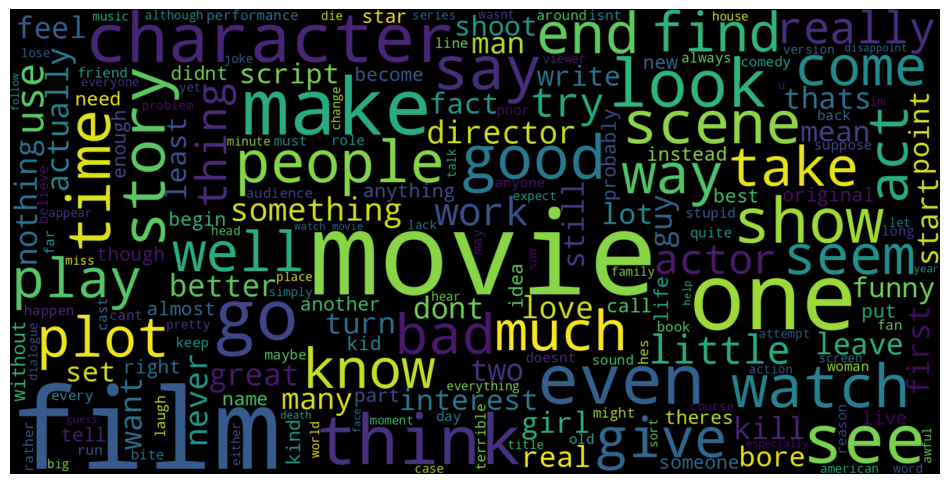

In [23]:
#create corpus with negative santiments
neg_corpus = " ".join(review for review in neg_data["review"].astype(str))

#print wordcloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(neg_corpus)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

##positive words

In [24]:
#define positive sentiments
pos_data = data_lem[data_lem["sentiment"]==1].copy()

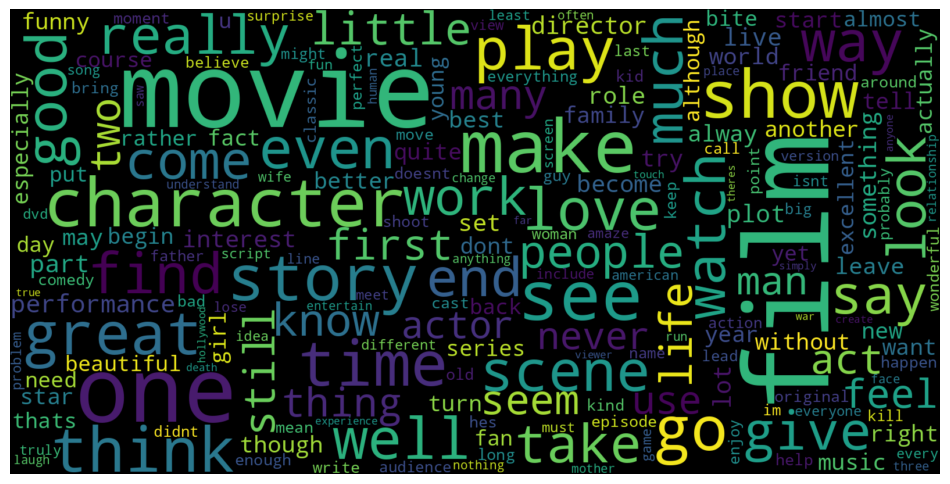

In [25]:
#create corpus with positive santiments
pos_corpus = " ".join(review for review in pos_data["review"].astype(str))

#print wordcloud
wordcloud = WordCloud(width=1600, height=800, max_font_size=200).generate(pos_corpus)
plt.figure(figsize=(12,10))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

Conclusion
 as we can see from below plots: *words great, good, love* appear most frequently in positive sentiments.

 words *bad, end* in negative

 but most frequently words apeear in same way

#CountVectorizer

In [26]:
#define vectorizer
vectorizer = CountVectorizer(max_features=10000)

In [27]:
#define data copy
vect_data = data_lem.copy()

In [28]:
phrase = np.array(vect_data["review"])

In [29]:
X = vectorizer.fit_transform(phrase)

In [30]:
print(X.toarray())

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [31]:
column_means = np.mean(X.toarray(), axis=0)

print(column_means)

[0.0028 0.0115 0.0015 ... 0.0011 0.001  0.0009]


In [32]:
len(vect_data["sentiment"]), len(X.toarray())

(10000, 10000)

##train test split

In [33]:
#define X and y
X_vec = X.toarray()
y_vec = vect_data["sentiment"]

In [34]:
#split into train test data
X_vec_train, X_vect_test, y_vec_train, \
                          y_vec_test = train_test_split(X_vec, y_vec, train_size=0.8,
                                                        random_state=42)

##LightGBM

In [35]:
#define light gbm
lgbm = lightgbm.LGBMClassifier(random_state=42)

In [36]:
# make baseline pipeline
lgbm_pipeline = make_pipeline(scaler, lgbm)

In [37]:
lgbm_pipeline.fit(X_vec_train, y_vec_train)

[LightGBM] [Info] Number of positive: 4024, number of negative: 3976
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 1.152204 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21283
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503000 -> initscore=0.012000
[LightGBM] [Info] Start training from score 0.012000


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [38]:
#cross validation
lgbm_cv = cross_val_score(lgbm_pipeline, X_vec_train, y_vec_train, cv=5)

[LightGBM] [Info] Number of positive: 3219, number of negative: 3181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.585085 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18042
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 3838
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502969 -> initscore=0.011875
[LightGBM] [Info] Start training from score 0.011875
[LightGBM] [Info] Number of positive: 3219, number of negative: 3181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.660142 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 18012
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 3819
[LightGBM] [Info] [b

In [39]:
#baseline score
lgbm_score = lgbm_cv.mean()

print(f"the lightgbm classifier cv score is {lgbm_score}")

the lightgbm classifier cv score is 0.84475


### classification report

In [40]:
#predict data
lgbm_pred = lgbm_pipeline.predict(X_vect_test)

In [41]:
# print classification report
print(classification_report(y_vec_test, lgbm_pred))

              precision    recall  f1-score   support

           0       0.88      0.84      0.86       996
           1       0.85      0.89      0.87      1004

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000



#TfidfVectorizer

In [42]:
#define tf vectorizer
tf = TfidfVectorizer(max_features=10000)

In [43]:
X_tf = tf.fit_transform(phrase)

##train test split

In [44]:
#define X and y
X_tf = X_tf.toarray()
y_tf = vect_data["sentiment"]

In [45]:
#split into train test data
X_tf_train, X_tf_test, y_tf_train, \
                          y_tf_test = train_test_split(X_tf, y_tf, train_size=0.8,
                                                        random_state=42)

##LightGBM

In [46]:
# make baseline pipeline
lgbm_pipeline_tf = make_pipeline(scaler, lgbm)

In [47]:
lgbm_pipeline_tf.fit(X_tf_train, y_tf_train)

[LightGBM] [Info] Number of positive: 4024, number of negative: 3976
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 1.273878 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 185481
[LightGBM] [Info] Number of data points in the train set: 8000, number of used features: 4501
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.503000 -> initscore=0.012000
[LightGBM] [Info] Start training from score 0.012000


Pipeline(steps=[('standardscaler', StandardScaler()),
                ('lgbmclassifier', LGBMClassifier(random_state=42))])

In [48]:
#cross validation
lgbm_cv_tf = cross_val_score(lgbm_pipeline_tf, X_tf_train, y_tf_train, cv=5)

[LightGBM] [Info] Number of positive: 3219, number of negative: 3181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.505762 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150173
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 3838
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.502969 -> initscore=0.011875
[LightGBM] [Info] Start training from score 0.011875
[LightGBM] [Info] Number of positive: 3219, number of negative: 3181
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.467793 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 150355
[LightGBM] [Info] Number of data points in the train set: 6400, number of used features: 3819
[LightGBM] [Info] 

In [49]:
#baseline score
lgbm_score_tf = lgbm_cv_tf.mean()

print(f"the lightgbm classifier cv score is {lgbm_score_tf} ")

the lightgbm classifier cv score is 0.8402499999999999 


### classification report

In [50]:
#predict data
lgbm_pred_tf = lgbm_pipeline_tf.predict(X_tf_test)

In [51]:
# print classification report
print(classification_report(y_tf_test, lgbm_pred_tf))

              precision    recall  f1-score   support

           0       0.87      0.84      0.86       996
           1       0.85      0.88      0.86      1004

    accuracy                           0.86      2000
   macro avg       0.86      0.86      0.86      2000
weighted avg       0.86      0.86      0.86      2000

